# 10. Single-layer Neural Network with Pattern images based on Lengyel-Epstein model¶
- X : imges, Z = W1 * gradient(X) + W2 * (X-X^3) + b
- optimizer : Adam with L2

## 1) Import Packages

In [198]:
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import math
import sklearn.metrics as metrics

## 2) Make Dataset

In [199]:
# Make dataset
x_orig = []
y_orig = np.zeros((1,120))
for i in range(1,361):
    if i <= 120 :
        folder = 0
    elif i <=240 :
        folder = 1
    else:
        folder = 2

    img = Image.open('360/{0}/pattern_{1}.jpg'.format(folder,i)) 
    data = np.array(img)
    x_orig.append(data)

for i in range(1,3):
    y_orig = np.append(y_orig, np.full((1, 120),i), axis = 1)

In [200]:
# Explore dataset
x_orig = np.array(x_orig)
print(x_orig.shape)
print(y_orig.shape)  

(360, 64, 64)
(1, 360)


In [201]:
# Random shuffle
s = np.arange(x_orig.shape[0])
np.random.shuffle(s)

x_shuffle = x_orig[s,:]
y_shuffle = y_orig[:,s]

print(x_shuffle.shape)
print(y_shuffle.shape)
# y_shuffle

(360, 64, 64)
(1, 360)


In [202]:
# Split train and test datasets
x_train_orig, x_test_orig, y_train_orig, y_test_orig = train_test_split(x_shuffle,y_shuffle.T, 
                                                                        test_size=0.3,  shuffle=True, random_state=1005)

In [203]:
print(x_train_orig.shape)
print (y_train_orig.shape)
print(sum(y_train_orig==0))
print(sum(y_train_orig==1))
print(sum(y_train_orig==2))

(252, 64, 64)
(252, 1)
[83]
[83]
[86]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


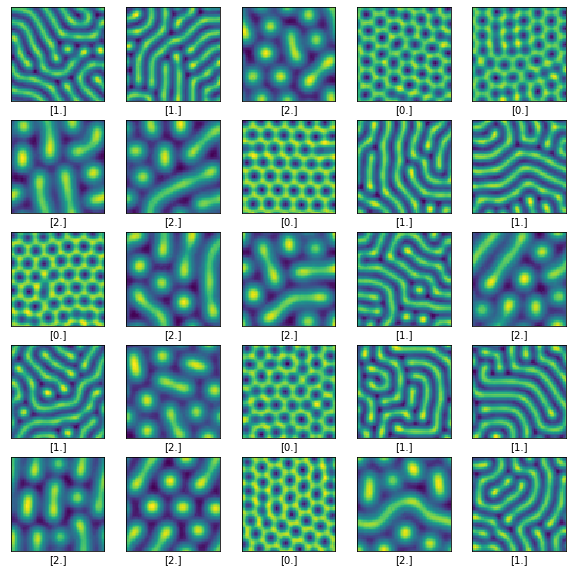

In [204]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_orig[i,:])
    plt.xlabel(y_train_orig[i,:])
plt.show()

In [205]:
# Flatten the training and test images
x_train_flatten = x_train_orig.reshape(x_train_orig.shape[0], -1).T
x_test_flatten = x_test_orig.reshape(x_test_orig.shape[0], -1).T

# Normalize image vectors
x_train = (2/255)*x_train_flatten - 1
x_test = (2/255)*x_test_flatten - 1

# Convert training and test labels to one hot matrices
enc = OneHotEncoder()
y1 = y_train_orig.reshape(-1,1)
enc.fit(y1)
y_train = enc.transform(y1).toarray()
y_train = y_train.T

y2 = y_test_orig.reshape(-1,1)
enc.fit(y2)
y_test = enc.transform(y2).toarray()
y_test = y_test.T

# Explore dataset 
print ("number of training examples = " + str(x_train.shape[1]))
print ("number of test examples = " + str(x_test.shape[1]))
print ("x_train shape: " + str(x_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("x_test shape: " + str(x_test.shape))
print ("y_test shape: " + str(y_test.shape))

number of training examples = 252
number of test examples = 108
x_train shape: (4096, 252)
y_train shape: (3, 252)
x_test shape: (4096, 108)
y_test shape: (3, 108)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you us

## 3) Define required functions

In [206]:
def initialize_parameters(nx, ny):
    """
    Argument:
        nx -- size of the input layer (4096)
        ny -- size of the output layer (3)
    
    Returns:
        W -- weight matrix of shape (ny, nx)
        b -- bias vector of shape (ny, 1)

    """   
    np.random.seed(1)

    W1 = np.random.randn(ny,nx)*0.01
    W2 = np.random.randn(ny,nx)*0.01
    b = np.zeros((ny,1))

    assert(W1.shape == (ny, nx))
    assert(W2.shape == (ny, nx))
    assert(b.shape == (ny, 1))

    
    return W1,W2, b  

In [207]:
def softmax(Z):
    # compute the softmax activation
    
    S = np.exp(Z + np.max(Z)) / np.sum(np.exp(Z + np.max(Z)), axis = 0)
    
    return S

In [208]:
def classlabel(Z):
    # probabilities back into class labels
    y_hat = Z.argmax(axis=0)
    
    return y_hat

In [209]:
def gradient_vec(X):
    g_X_r = np.gradient(X, axis = 1)
    g_X_c = np.gradient(X, axis = 0)
    g_X = g_X_r**2 + g_X_c**2
    return g_X

In [210]:
def propagate(W1,W2, b, X, Y, lambd):

    m = X.shape[1]
#     n = Y.shape[0]
    
    # Forward Propagation
    Z = np.dot(W1, gradient_vec(X))+ np.dot(W2, X-X**3) + b
    A = softmax(Z)     # compute activation
    
    cost = (-1/m) * (np.sum(Y * np.log(A))) # compute cost (Cross_entropy)
     
    # Backward propagation   
    dW1 = (1/m) * (np.dot(gradient_vec(X),(A-Y).T)).T 
    dW2 = (1/m) * (np.dot(X-X**3, (A-Y).T).T) 
    db = (1/m) * (np.sum(A-Y))
    
#     assert(dW.shape == W.shape)
#     assert(db.dtype == float)
#     cost = np.squeeze(cost)
#     assert(cost.shape == (Y.shape[0],1))
    
    grads = {"dW1": dW1,
             "dW2": dW2, 
             "db": db}
    
    return grads, cost

## 4) Single-2weight(X-X^3) Layer Neural Network with Adam + L2

In [219]:
def optimize(X, Y, num_iterations, learning_rate, t, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, print_cost = False
            , lambd = 0.01):
    
    m = X.shape[1]
    costs = []
    W1, W2, b = initialize_parameters(4096,3)
    
     # initialize with adam
    v_dW1 = np.zeros((W1.shape[0],W1.shape[1]))
    v_dW2 = np.zeros((W2.shape[0],W2.shape[1]))
    v_db = np.zeros((b.shape[0],b.shape[1]))
    
    s_dW1 = np.zeros((W1.shape[0],W1.shape[1]))
    s_dW2 = np.zeros((W2.shape[0],W2.shape[1]))
    s_db = np.zeros((b.shape[0],b.shape[1]))
    
    for i in range(num_iterations):
        t +=1
        grads, cost = propagate(W1,W2, b, X, Y, lambd)

        dW1 = grads["dW1"]
        dW2 = grads["dW2"]
        db = grads["db"]
        
        # update parameters with adam
        v_dW1 = beta1 * v_dW1 + (1-beta1) * dW1
        v_dW2 = beta1 * v_dW2 + (1-beta1) * dW2
        v_db = beta1 * v_db + (1-beta1) * db

        # Compute bias-corrected first moment estimate
        v_corrected_dW1 = v_dW1 / (1-beta1**t)
        v_corrected_dW2 = v_dW2 / (1-beta1**t)
        v_corrected_db = v_db / (1-beta1**t)
        
        # Moving average of the squared gradients
        s_dW1 = beta2 * s_dW1 + (1-beta2) * dW1 ** 2
        s_dW2 = beta2 * s_dW2 + (1-beta2) * dW2 ** 2
        s_db = beta2 * s_db + (1-beta2) * db ** 2

        # Compute bias-corrected second raw moment estimate.
        s_corrected_dW1 = s_dW1 / (1-beta2**t)
        s_corrected_dW2 = s_dW2 / (1-beta2**t)
        s_corrected_db = s_db / (1-beta2**t)

        # Update parameters
        W1 = W1 - (learning_rate) * ((v_corrected_dW1) / (s_corrected_dW1 **(1/2) + epsilon)+ (lambd)*W1)
        W2 = W2 - (learning_rate) * ((v_corrected_dW2) / (s_corrected_dW2 **(1/2) + epsilon)+ (lambd)*W2)
        b = b - (learning_rate) * ((v_corrected_db) / (s_corrected_db ** (1/2) + epsilon))

        # Record the costs for plotting
        if i % 10 == 0:
            costs.append(cost)
            
        # Print the cost every 100 training iterations
        if print_cost and i % 10 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per 200)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    # Lets save the trainded parameters in a variable
    params = {"W1": W1,
              "W2": W2,
              "b": b}    
    grads = {"dW1": dW1,
             "dW2":dW2,
             "db": db}
    
    return params, grads, costs

Cost after iteration 0: 1.103945
Cost after iteration 10: 0.105801
Cost after iteration 20: 0.006082
Cost after iteration 30: 0.000573
Cost after iteration 40: 0.000163


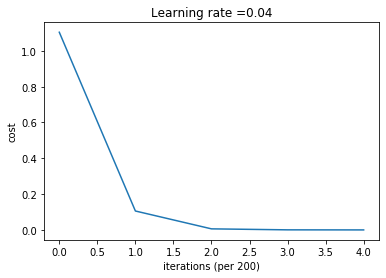

W1 = [[-0.23489222 -0.24462242 -0.17586267 ... -0.04513905 -0.09421232
  -0.12333578]
 [ 0.08039003  0.1085258   0.12166116 ... -0.27301982 -0.20001115
  -0.04771144]
 [ 0.17065549  0.18203365  0.12169701 ...  0.19075311  0.21030811
   0.20373795]]
W2 = [[ 0.39329213  0.3295831   0.27963001 ...  0.06507096  0.12278107
   0.14447081]
 [-0.35244323 -0.3876112  -0.35073228 ...  0.15280856  0.06652239
  -0.00413179]
 [-0.35178871 -0.22091409 -0.17518442 ... -0.27205374 -0.25540515
  -0.22109279]]
b = [[-1.95091987e-11]
 [-1.95091987e-11]
 [-1.95091987e-11]]


In [223]:
params, grads, costs = optimize(x_train, y_train, num_iterations=50,learning_rate=0.04,
                                t=2, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, print_cost = True, lambd = 0)
print ("W1 = " + str(params["W1"]))
print ("W2 = " + str(params["W2"]))
print ("b = " + str(params["b"]))

## 5) Accuracy Analysis

In [224]:
def predict(W1, W2, b, X) :

    m = X.shape[1]
    
    # Compute "A" predicting the probabilities
    Z = np.dot(W1, gradient_vec(X))+ np.dot(W2, X-X**3) + b
    A = softmax(Z) 

    # Convert probabilities A to actual predictions
    y_prediction = A.argmax(axis=0)
    
#     assert(y_prediction.shape == (1, m))
    
    return y_prediction

In [225]:
# Predict test/train set
W11 = params['W1']
W22 = params['W2']
b11= params['b']

y_prediction_train = predict(W11,W22, b11, x_train)
y_prediction_test = predict(W11,W22, b11, x_test)

print(y_prediction_train)
print(y_prediction_test)

# Print train/test Errors
print("train accuracy : ", metrics.accuracy_score(y_prediction_train, y_train_orig))
print("test accuracy : ", metrics.accuracy_score(y_prediction_test, y_test_orig))

[1 1 2 0 0 2 2 0 1 1 0 2 2 1 2 1 2 0 1 1 2 2 0 2 1 1 0 2 1 1 2 1 1 2 2 0 2
 2 2 1 1 0 2 0 2 1 0 1 1 2 0 2 0 0 0 1 0 0 0 1 2 2 1 0 1 1 2 1 1 2 1 1 0 0
 2 2 0 0 1 2 0 0 1 1 0 1 0 2 2 1 2 1 0 1 2 1 0 1 2 2 0 0 2 1 1 0 1 2 0 0 2
 2 2 2 2 1 2 2 0 1 0 0 0 0 1 0 1 2 1 2 2 0 0 2 0 1 1 1 0 0 2 0 1 2 1 2 2 0
 0 1 0 1 1 1 1 2 2 2 1 0 0 1 0 2 2 2 1 2 2 1 1 0 1 0 0 2 2 1 0 2 2 0 2 1 2
 2 0 0 0 2 1 2 2 0 1 0 0 1 0 2 0 1 2 0 2 2 0 0 1 0 1 0 2 2 2 0 1 0 2 1 1 1
 1 1 0 0 0 2 1 1 2 2 0 1 2 2 2 0 1 1 1 0 0 1 1 2 2 0 0 0 2 0]
[1 0 0 0 0 0 2 2 2 0 2 1 1 2 0 0 1 1 0 0 0 2 1 2 0 1 2 0 2 1 0 2 0 1 2 0 1
 2 2 0 0 1 2 2 0 2 0 0 0 1 2 1 0 0 0 2 2 2 2 1 1 1 2 0 0 1 2 0 0 1 2 1 1 2
 1 1 0 0 0 2 2 2 1 0 1 1 1 2 1 0 1 0 0 2 0 0 1 2 1 0 0 2 2 1 0 2 1 2]
train accuracy :  1.0
test accuracy :  0.8981481481481481
